要构建Transformer模型，需要以下步骤：
- 导入库和模块
- 定义基本构建块-多头注意力、前馈神经网络、位置编码
- 构建编码器块
- 构建解码器块
- 结合编码器和解码器层，创建完整的变压器网络

## 1.导入库和模块

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

## 2.定义基本构建块-多头注意力、前馈神经网络、位置编码

### 2.1 Multi-head Attention

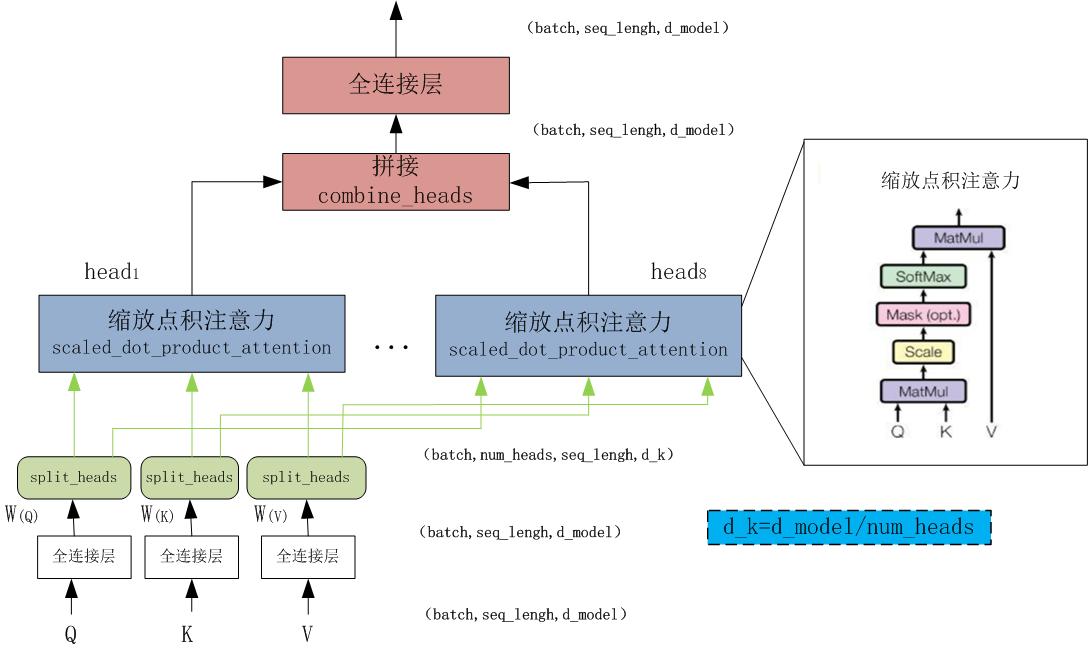

<font color=blue>这里使用继承nn.Module基类来构建神经网络：</font>    
<font color=blue>1.先定义一个类，使之继承nn.Module基类；</font>    
<font color=blue>2.在构造函数（即 def __init__()函数）中定义网络层，张量等</font>    
<font color=blue>3.在forward方法中实现正向传播</font>

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # 确保模型维度d_model能被头数（number of heads）整除，这个整除数为d_k
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # 初始化维度
        self.d_model = d_model # 模型维度
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # 每个头的K,Q,V的维度
        
        # 用于转换输入的线性层
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # 计算注意力得分，transpose为转置函数,把第-2，-1轴互换
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 如果提供了掩码（mask），则应用它（这对于防止对某些部分（如填充部分）的关注很有用）
        if mask is not None:
            #把矩阵mask中值为0或False的值替换为负无穷大（这里用-le9代替）
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # 利用函数Softmax计算注意力概率分布，按最后一个轴计算（如mxn矩阵，按同行不同列） 
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # 与V相乘以获得最终输出
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # 修改输入尺寸大小，使其具有num_heads，以实现多头注意力
        #x的维度为(batch_size, seq_length, d_model)
        #这里主要把d_model维度拆分为num_headers分配给每个head,每份的维度变为d_k(=d_model/num_heads)
        #同时x的维度由3维变为4维
        #输出维度为(batch_size,num_heads,seq_length, d_k)
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)#交换维度1,2的位置
        
    def combine_heads(self, x):
        # 将多个头组合回原始形状
        #x的维度为(batch_size,num_heads,seq_length,d_k)
        #通过view方法，把num_heads与d_k合并一个，其长度变为d_model
        #输入维度由(batch_size,num_heads,seq_length, d_k) 变为(batch_size,seq_length, d_model)
        batch_size, _, seq_length, d_k = x.size()
        #contiguous()将返回一个内存连续的张量，以便后面的view操作
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # 使用全连接层分拆d_model成num_heads给每个head
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # 计算缩放点积注意力
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 拼接num_heads个heads，并通过全连接层输出Z
        output = self.W_o(self.combine_heads(attn_output))
        return output

<font color=blue size=3>PyTorch中，contiguous()函数的主要作用是将一个‌Tensor的内存布局转换为连续的，以确保某些操作可以正确执行或提高性能。 当Tensor通过某些操作（如转置或切片）后，其内存布局可能不再连续，这时调用contiguous()函数可以创建一个新的连续的Tensor，它重新排列数据以确保内存布局的连续性。这种连续性对于如view()这样的操作至关重要，因为这些操作要求Tensor的内存是连续存储的。此外，contiguous()函数通过返回一个新的Tensor来实现，原始Tensor不会被改变。这种连续的内存布局可以优化数据访问和处理效率，因为处理器可以按照内存地址的顺序依次读取数据，而不需要在不同的内存位置之间进行跳转</font>

### 该类被定义为PyTorch's nn.Module的子类。
- d_model: Dimensionality of the input.
- num_heads: The number of attention heads to split the input into.

### def scaled_dot_product_attention(self, Q, K, V, mask=None):
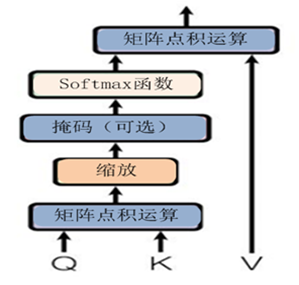
- 计算注意力得分：attn_Scores=torch.matmul（Q，K.转置（-2，-1））/math.sqrt（self.d.K）。这里，注意力得分是
- 通过取查询（Q）和键（K）的点积然后按键维度$（d_K）$ 的平方根缩放来计算。
- 应用掩码：如果提供了掩码，则将其应用于注意力得分以掩盖特定值。
- 计算注意力权重：注意力得分通过softmax函数转换为总和为1的概率。
- 计算输出：注意力的最终输出是通过将注意力权重乘以值（V）来计算的。

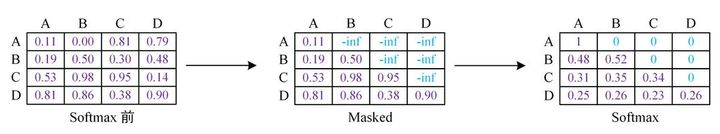

### def split_heads(self, x):
此方法将输入x重新变形形为形状（batch_size，num_heads，seq_length，$d_k$）。它使模型能够同时处理多个注意力，从而允许并行计算。

### def combine_heads(self, x):
在分别关注每个头部后，该方法将结果组合回一个形状张量（batch_size、seq_length、$d_{model}$）。这为进一步处理结果做好了准备。

### def forward(self, Q, K, V, mask=None):
- 正向方法是实际计算发生的地方：
- 应用线性变换：首先使用初始化中定义的权重对查询（Q）、键（K）和值（V）进行线性变换。
- 拆分头部：使用Split_Heads方法将转换后的Q、K、V拆分为多个头部。
- 应用缩放点产品注意力：在拼合头上调用Scaled.Dot_Product_Attention方法。
- 合并头部：使用Combine_Heads方法将每个头部的结果合并回一个张量。
- 应用输出变换：最后，组合张量通过输出线性变换。

总之，MultiHeadAttention类封装了Transformer模型中常用的多头注意机制。它负责将输入拆分为多个注意力头部，将注意力应用于每个头部，然后组合结果。通过这样做，模型可以在不同尺度上捕捉输入数据中的各种关系，提高模型的表达能力。

### 2.2 前馈神经网络

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### def __init__(self, d_model, d_ff):
- d_model：模型输入和输出的维度。
- d_ff：前馈网络内层的维数。
- self.fc1和self.fc2：两个完全连接的（线性）层，其输入和输出维度由d_model和d_ff定义。
- self.relu：relu（校正线性单元）激活函数，在两个线性层之间引入非线性。

### def forward(self, x):
- x：前馈网络的输入。
- self.fc1（x）：输入首先通过第一线性层（fc1）。
- self.relu（…）：fc1的输出然后通过relu激活函数传递。ReLU将所有负值替换为零
- 将非线性引入模型。
- self.fc2（…）：激活的输出然后通过第二线性层（fc2），产生最终输出。

总之，PositionWiseFeedForward类定义了一个位置前馈神经网络，该网络由两个线性层组成，中间有ReLU激活函数。在Transformer模型的背景下，这种前馈网络被单独且相同地应用于每个位置。它有助于转换由转换器内的注意力机制学习到的特征，作为注意力输出的额外处理步骤。

### 2.3 位置编码

位置编码用于在输入序列中注入每个标记（Token）的位置信息。它使用不同频率的正弦和余弦函数来生成位置编码
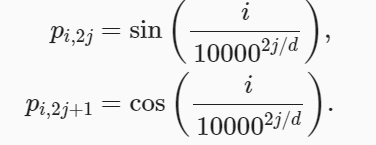

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        #生成一个0矩阵，尺寸大小为(max_seq_length, d_model)
        pe = torch.zeros(max_seq_length, d_model)
        #生成一个由0到max_seq_length（小于这个值）的序列，并在第二个位置增加一个维度
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        #计算公式中括号中指
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        #列索引为偶数，置为sin值，列索引为奇数的置为cos值
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe.unsqueeze(0)增加一个维度，然后注册张量pe，使之变为不参与更新的参数
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

<font color=blue>1.通过register_buffer()登记过的张量：会自动成为模型中的参数，随着模型移动（gpu/cpu）而移动，但是不会随着梯度进行更新</font>  
<font color=blue>2.在PyTorch中，unsqueeze(0)是一个常用的函数，它用于在张量的指定维度上插入一个新的维度，新的维度大小为1。例如，如果你有一个形状为(3,)的张量，使用unsqueeze(1)会使其形状变为(1,3)。</font>

### def __init__(self, d_model, max_seq_length)

- d_model：模型输入的维度。
- max_seq_length：预先计算位置编码的序列的最大长度。
- pe：一个用零填充的张量，它将用位置编码填充。
- position：包含序列中每个位置的位置索引的张量。
- div_term：用于以特定方式缩放位置索引的术语。
- 正弦函数应用于pe的偶数索引，余弦函数应用于pe的奇数索引。
- 最后，pe被注册为缓冲区，这意味着它将是模块状态的一部分，但不会被视为可训练参数。

### def forward(self, x):

正向方法简单地将位置编码添加到输入x。
它使用pe的前x.size（1）个元素来确保位置编码与x的实际序列长度匹配。

## 3. 构建编码器层

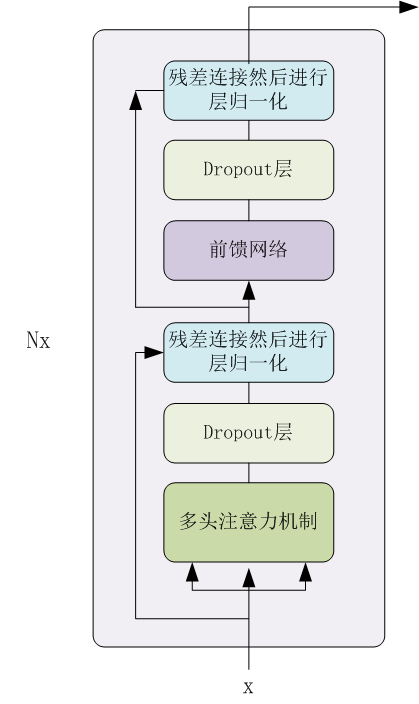

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        #初始化类
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        #先残差连接，然后再进行层归一化
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

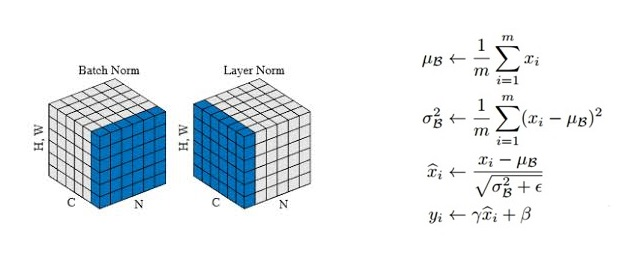
N为batch size，C为channel（通道数），H,W代表每个特征向量的高和宽。
简单的理解就是BatchNorm是对一个batch size样本内的每个特征做归一化，LayerNorm是对每个样本的所有特征做归一化，LayerNorm善于处于输入为不定长的数据。

### Initialization:
参数：
- d_model：输入的维度。
- num_heads：多头注意力中的注意力头数。
- d_ff：位置前馈网络中内层的维度。
- dropout：用于正规化的辍学率。

组件：
- self.self_attn：多头注意力机制。
- self.feed_forward: 位置前馈神经网络。
- self.norm1和self.norm2：层归一化，用于平滑层的输入。
- self.dropout：Dropout层，用于通过在训练期间随机将一些激活设置为零来防止过拟合。

### Forward Method:
输入:
- x：编码器层的输入。
- mask：可选掩码，用于忽略输入的某些部分。

操作步骤：
- 自注意力：输入x通过多头自注意力机制传递。
- 添加并归一化（在注意力之后）：将注意力输出添加到原始输入（残差连接），然后使用 norm1 进行 dropout 和归一化。
- 前馈网络：前一步的输出通过位置前馈网络传递。
- 添加并归一化（前馈后）：与步骤2类似，将前馈输出添加到该阶段的输入（残差连接），然后使用norm2进行dropout和归一化。
- 输出：经过处理的张量作为编码器层的输出返回。

### 小结
EncoderLayer类定义了 transformer 编码器的单层。它封装了一个多头自注意力机制，后面是位置前馈神经网络，并适当地应用了残差连接、层归一化和 dropout。这些组件共同使编码器能够捕捉输入数据中的复杂关系，并将其转化为下游任务的有用表示。通常，多个这样的编码器层被堆叠起来，形成 transformer 模型的完整编码器部分。

### 4. 构建解码器层
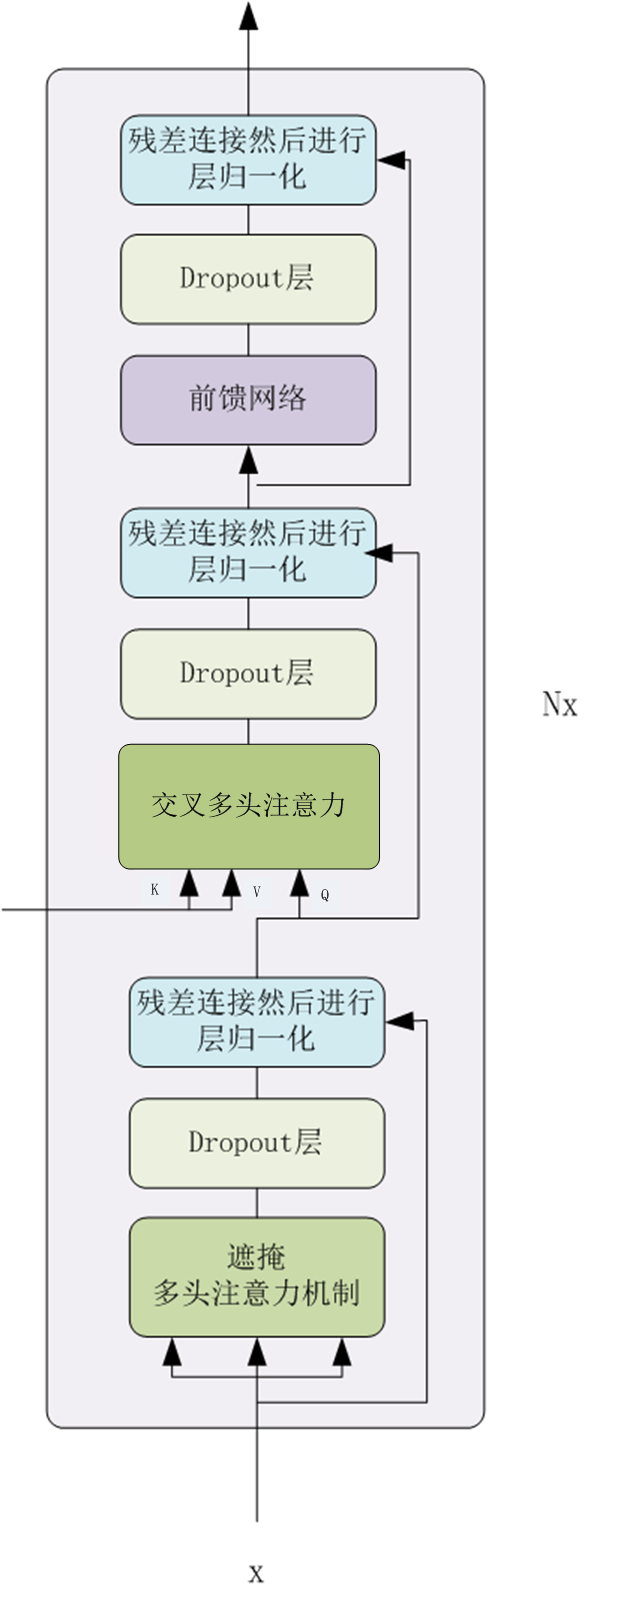

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        #定义交叉注意力层，该层的输入K,V来自编码器层，Q来自下层的输出
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        #enc_output为编码器层的输出
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

Decoder Block的架构大体上和Encoder Block是一致的，唯独不同的是Decoder比Encoder多了Masked Multi-Head Attention。
那么为什么要在Decode阶段对特征（或者说tokens）做mask呢？
Mask的样式如下，白格为0，蓝格为1, 1表示保留的部分，0表示mask的部分
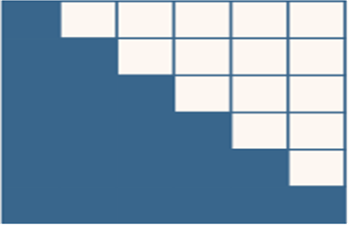
ransformer针对序列化特征，比如文本数据，这些特征是有前后关系的，为了不让Decoder通过未来的单词（或者说特征）来猜测出当前的特征，将后面的token进行mask，这样模型只能通过过去的词或者说特征元素来预测当前特征元素。

### def __init__(self, d_model, num_heads, d_ff, dropout):

参数：
- d_model: 输入的维度。
- num_heads：多头注意力中的注意力头数。
- d_ff：前馈网络中内层的维度。
- dropout：正则化的丢弃率。  

组件：
- self.self_attn：目标序列的多头自注意力机制。
- self.cross_attn：关注编码器输出的多头注意力机制。
- self.feed_forward: 位置前馈神经网络。
- self.norm1，self.norm2，self.norm3：层归一化组件。
- self.dropout: 用于正则化的丢弃层。

### Forward Method:

输入：
- x：解码器层的输入。
- enc_output：来自相应编码器的输出（在跨注意力步骤中使用）。
- src_mask：源掩码，用于忽略编码器输出的某些部分。
- tgt_mask：目标掩码，用于忽略解码器输入的某些部分。

操作步骤：
- 目标序列上的自注意力：输入x通过自注意力机制进行处理。
- 添加并归一化（在自注意力之后）：将自注意力的输出添加到原始的x中，然后使用norm1进行dropout和归一化。
- 与编码器输出的交叉注意力：通过交叉注意力机制处理前一步的标准化输出，该机制关注编码器的输出enc_output。
- 添加并归一化（在交叉注意之后）：将交叉注意的输出添加到该阶段的输入中，然后使用 norm2 进行 dropout 和归一化。
- 前馈网络：前一步的输出通过前馈网络传递。
- 添加并归一化（在前馈之后）：前馈输出被添加到该阶段的输入中，然后使用 norm3 进行 dropout 和归一化。
输出：处理后的张量作为解码器层的输出返回。

摘要：DecoderLayer类定义了 transformer 解码器的单层。它由多头自注意力机制、多头交叉注意力机制（关注编码器的输出）、位置前馈神经网络以及相应的残差连接、层归一化和丢弃层组成。这种组合使解码器能够根据编码器的表示生成有意义的输出，同时考虑目标序列和源序列。与编码器一样，通常将多个解码器层堆叠起来，以形成 transformer 模型的完整解码器部分。接下来，编码器和解码器模块被组合在一起，以构建综合的Transformer模型。

## 5. 结合编码器层和解码器层，创建完整的Transformer网络
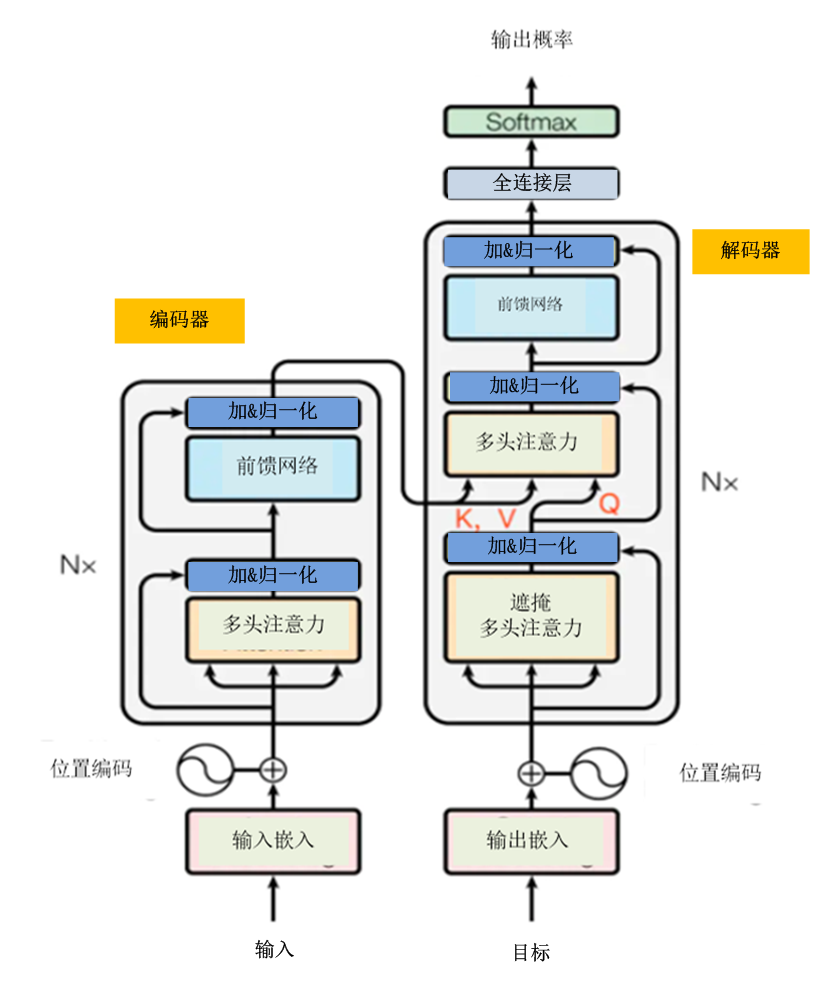

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        #定义嵌入层
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        #构建编码器和解码器
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        #定义输出层
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        #把src变为逻辑值，如True，并在1,2轴增加维度,src的尺寸由[64, 10]变为[64, 1, 1, 10]
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        #把tgt变为逻辑值，如True，并在1,3轴增加维度,tgt的尺寸由[64, 10]变为[64, 1, 10, 1]
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        #获取tgt尺寸中表示序列长度的值
        seq_length = tgt.size(1)
        #生成一个[1,seq_length,seq_length]上三角矩阵,对角线及以下为True，上三角为False
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        #把参与训练的数据迁移到GPU上
        nopeak_mask=nopeak_mask.to(device)
        #实现逻辑与的计算,使生成数据看不到未来的数据
        tgt_mask = tgt_mask & nopeak_mask        
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

### Initialization:

构造函数接受以下参数：
- src_vocab_size：源词汇表大小。
- tgt_vocab_size：目标词汇表大小。
- d_model: 模型的嵌入维数，即每个标记的维度。
- num_heads：多头注意力机制中的注意力头数。
- num_layers：编码器和解码器的层数。
- d_ff：前馈网络中内层的维度。
- max_seq_length：位置编码的最大序列长度，即每个序列的时间步长。
- dropout: 用于正则化的丢弃率。

它定义了以下组件：
- self.encoder_embedding: 源序列的嵌入层。
- self.decoder_embedding: 目标序列的嵌入层。
- self.positional_encoding: 位置编码组件。
- self.encoder_layers: 编码器层的列表。
- self.decoder_layers: 译码器层的列表。
- self.fc：映射到目标词汇大小的最终全连接（线性）层。
- self.dropout: 丢弃层。

### Generate Mask Method:

该方法用于为源序列和目标序列创建掩码，确保填充标记被忽略，并且在目标序列的训练过程中未来的标记不可见。

### Forward Method:
此方法定义了 Transformer 的正向传递，获取源序列和目标序列并生成输出预测。

- 输入嵌入和位置编码：首先使用各自的嵌入层对源序列和目标序列进行嵌入，然后将其添加到位置编码中。
- 编码器层：源序列通过编码器层，最终编码器输出表示处理的源序列。
- 解码器层：目标序列和编码器的输出通过解码器层，产生解码器的输出。
- 最终线性层：解码器的输出使用全连接（线性）层映射到目标词汇表大小。

输出：

最终输出是一个表示模型对目标序列预测的张量。

摘要：

Transformer类汇集了Transformer模型的各种组件，包括嵌入、位置编码、编码器层和解码器层。它为训练和推理提供了一个方便的接口，封装了多头注意力、前馈网络和层归一化的复杂性。
此实现遵循标准的Transformer架构，使其适用于机器翻译、文本摘要等序列到序列的任务。掩蔽的引入确保了模型遵循序列内的因果依赖关系，忽略填充标记并防止未来标记的信息泄漏。
这些连续步骤使Transformer模型能够有效地处理输入序列并产生相应的输出序列。

## 6 训练Transformer模型

### 【说明】
torch.randint(low=0, high, size) 返回一个张量，其中充满在low(包含)和high(不包含)之间均匀生成的随机整数。

### 超参数：
这些值定义了变压器模型的架构和行为：
- src_vocab_size，tgt_vocab_size：源序列和目标序列的词汇表大小，均设置为 5000。
- d_model: 模型的嵌入维数，设置为 512。
- num_heads：多头注意力机制中的注意力头数，设置为8。
- num_layers：编码器和解码器的层数，设置为 6。
- d_ff：前馈网络中内层的维度，设置为2048。
- max_seq_length：位置编码的最大序列长度，设置为 100。
- dropout: 用于正则化的 dropout 比例，设置为 0.1。对于网络中的每一层，在每次前向传播时，都会根据这个比例（在这个例子中是10%）随机选择一部分神经元，将它们暂时从网络中移除（或说“丢弃”）。这些被丢弃的神经元的输出不再贡献给下一层，就好像它们不存在一样。但是，这些神经元的权重和偏置仍然保留，只是在这一次的前向传播和反向传播中不参与计算。

### Creating a Transformer Instance:
此行创建了Transformer类的实例，用给定的超参数对其进行初始化。该实例将具有这些超参数定义的架构和行为。
生成随机样本数据：
以下行生成随机源和目标序列：
- src_data：1 到 src_vocab_size 之间的随机整数，表示形状为 (64, max_seq_length) 的源序列批。
- tgt_data：1 到靶词汇表大小之间的随机整数，表示形状为 (64, max_seq_length) 的目标序列。

这些随机序列可以用作 transformer 模型的输入，模拟一批包含 64 个示例和长度为 100 的序列的数据。

### 训练模型
接下来，将使用上述样本数据对模型进行训练。然而，在现实场景中，将使用明显更大的数据集，通常会将其划分为不同的集合，用于训练和验证目的。

<font color=blue>contiguous()返回一个内存连续的有相同数据的tensor，如果原tensor内存连续，则返回原tensor。 一般与transpose，permute，view等方法搭配使用，view方法相当于reshape方法</font>

### 6.1合成数据

In [8]:
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048    #两个全连接层中的节点数
dropout = 0.1  #弃用一个节点的概率

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_seq_length1=10
src_vocab_size1=10
tgt_vocab_size1=10
batch_size=64
# 生成随机采样样本
src_data1 = torch.randint(1, src_vocab_size1, (batch_size, max_seq_length1))  # (batch_size, seq_length)
tgt_data1=src_data1
#tgt_data1 = torch.randint(1, tgt_vocab_size1, (batch_size, max_seq_length1))  # (batch_size, seq_length)
#把训练数据迁移到GPU
src_data1=src_data1.to(device)
tgt_data1=tgt_data1.to(device)

In [9]:
src_data1.shape

torch.Size([64, 10])

In [10]:
src_data1[:2,:]

tensor([[2, 2, 9, 5, 4, 5, 1, 1, 4, 9],
        [2, 2, 1, 2, 9, 4, 7, 3, 2, 7]], device='cuda:0')

In [11]:
tgt_data1[:2,:]

tensor([[2, 2, 9, 5, 4, 5, 1, 1, 4, 9],
        [2, 2, 1, 2, 9, 4, 7, 3, 2, 7]], device='cuda:0')

### 6.2 实例化模型

In [12]:
#实例化Transformer类
transformer1 = Transformer(src_vocab_size1, tgt_vocab_size1, d_model, num_heads, num_layers, d_ff, max_seq_length1, dropout)
#把模型迁移到GPU
transformer1=transformer1.to(device)


### 6.3 利用合成数据训练模型

In [13]:
#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer1.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

#设置训练模式
transformer1.train()

for epoch in range(100):
    #清除过往梯度
    optimizer.zero_grad()
    #前向传播
    output1 = transformer1(src_data1, tgt_data1)
    #定义损失值
    loss1 = criterion(output1.contiguous().view(-1, tgt_vocab_size1), tgt_data1.contiguous().view(-1))
    #反向传播，计算当前梯度
    loss1.backward()
    #根据梯度更新网络参数
    optimizer.step()
    if (epoch+1)%10 ==0 :
        print(f"Epoch: {epoch+1}, Loss: {loss1.item()}")

Epoch: 10, Loss: 0.016835642978549004
Epoch: 20, Loss: 0.0030325541738420725
Epoch: 30, Loss: 0.0009103090269491076
Epoch: 40, Loss: 0.0005160978762432933
Epoch: 50, Loss: 0.0003913769905921072
Epoch: 60, Loss: 0.0003277994110248983
Epoch: 70, Loss: 0.0002870150492526591
Epoch: 80, Loss: 0.00025896148872561753
Epoch: 90, Loss: 0.00023706739011686295
Epoch: 100, Loss: 0.00021953773102723062


### 损失函数和优化器：
- criterion = nn.CrossEntropyLoss(ignore_index=0)：将损失函数定义为交叉熵损失。ignore_index 参数设置为 0，这意味着损失函数不会考虑索引为 0 的目标（通常保留用于填充标记）。
- optimizer = optim.Adam(...): 将优化器定义为 Adam，学习率为 0.0001，并指定特定的 beta 值。

### 模型训练模式：
transformer.train(): 将 transformer 模型设置为训练模式，启用仅在训练期间应用的 dropout 等行为。

### 训练循环：
代码片段使用典型的训练循环对模型进行 100 个 epoch 的训练：
- epoch in range(100): 迭代 100 个训练 epoch。
- optimizer.zero_grad(): 清除前一次迭代的梯度。
- output = transformer(src_data, dst_data[:, :-1]): 将源数据和目标数据（不包括每个序列中的最后一个标记）传递给 transformer。这在序列到序列的任务中很常见，其中目标被移动了一个标记。
- loss = criterion(...): 计算模型预测值与目标数据之间的损失（不包括每个序列中的第一个标记）。损失是通过将数据重新整形为一维张量并使用交叉熵损失函数来计算的。
- loss.backward():计算损失相对于模型参数的梯度。
- optimizer.step(): 使用计算出的梯度更新模型的参数。
- print(f"Epoch: {epoch+1}, Loss: {loss.item()}"): 打印当前 epoch 编号和该 epoch 的损失值。

### 小结
此代码段在随机生成的源序列和目标序列上训练 transformer 模型 100 个 epoch。它使用 Adam 优化器和交叉熵损失函数。每个 epoch 的损失都会被打印出来，以便您监控训练进度。在现实场景中，您可以将随机源序列和目标序列替换为您的任务中的实际数据，例如机器翻译。